In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [75]:
data = pd.read_csv('/content/drive/My Drive/data/hanoi_quality.csv', index_col='date')

In [76]:
data

,pm25,pm10,o3,no2,so2,co
date,,,,,,
3/1/2019,76,1,15,36,7,7
3/2/2019,117,64,4,28,3,5
3/3/2019,10,64,1,22,16,5
3/4/2019,118,56,13,22,14,6
3/5/2019,2,34,15,21,6,6
...,...,...,...,...,...,...
5/28/2024,85,56,14,1,8,6
5/29/2024,58,50,13,1,8,6
5/30/2024,47,39,10,1,8,8


In [77]:
data.fillna(method='ffill', inplace=True)
scaler = MinMaxScaler()
data['pm25'] = scaler.fit_transform(data[['pm25']])

In [78]:
def create_sequences(data, seq_length=30):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
X, y = create_sequences(data['pm25'].values, seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [79]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(seq_length, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [80]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 30)                0         
                                                                 
 dense_30 (Dense)            (None, 128)               3968      
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dense_32 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12289 (48.00 KB)
Trainable params: 12289 (48.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [81]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/100
42/42 [==============================] - 1s 10ms/step - loss: 0.0255 - val_loss: 0.0248
Epoch 2/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0154 - val_loss: 0.0212
Epoch 3/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0139 - val_loss: 0.0213
Epoch 4/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0135 - val_loss: 0.0192
Epoch 5/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0131 - val_loss: 0.0246
Epoch 6/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0124 - val_loss: 0.0209
Epoch 7/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0118 - val_loss: 0.0192
Epoch 8/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0117 - val_loss: 0.0191
Epoch 9/100
42/42 [==============================] - 0s 3ms/step - loss: 0.0112 - val_loss: 0.0203
Epoch 10/100
42/42 [==============================] - 0s 3ms/step - loss: 0.0107 - val_loss: 0.0214
Epoch 11

In [82]:
# Predict the next 30 days PM2.5 values
last_sequence = X_test[-1]
predictions = []
current_sequence = last_sequence

for _ in range(30):
    next_value = model.predict(current_sequence[np.newaxis, :, :])[0, 0]
    predictions.append(next_value)
    current_sequence = np.append(current_sequence[1:], [[next_value]], axis=0)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
print("Next 30 days PM2.5 predictions:", predictions.flatten())

1/1 [==============================] - 0s 21ms/step
Next 30 days PM2.5 predictions: [82.57852  55.49666  55.011066 60.56075  61.87721  68.941734 52.323544
 44.91887  42.564312 42.894863 63.214825 59.24393  54.024864 48.003544
 54.77305  66.79003  57.162395 55.03994  48.863796 58.870808 76.60788
 59.836338 44.890003 51.261402 57.42129  62.872025 64.464966 65.24067
 72.40939  74.64781 ]


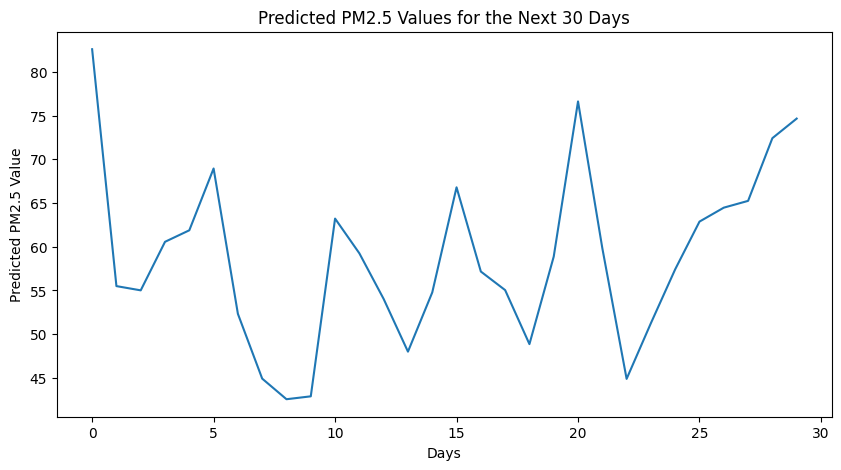

In [83]:
# Plot the predictions in the original scale
plt.figure(figsize=(10, 5))
plt.plot(predictions)
plt.title('Predicted PM2.5 Values for the Next 30 Days')
plt.xlabel('Days')
plt.ylabel('Predicted PM2.5 Value')
plt.show()